In [ ]:
!pip install datasets

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [3]:
import datasets

speaker_emb = datasets.load_dataset('Matthijs/cmu-arctic-xvectors', split='validation')
speaker_emb

Generating validation split:   0%|          | 0/7931 [00:00<?, ? examples/s]

Dataset({
    features: ['filename', 'xvector'],
    num_rows: 7931
})

In [4]:
import torch

speaker_emb_x =  torch.tensor(speaker_emb[7306]['xvector'])[None]
speaker_emb_x.shape, speaker_emb_x.dtype

(torch.Size([1, 512]), torch.float32)

In [5]:
inputs = processor(text="Don't count the days, make the days count.", return_tensors="pt")
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [6]:
spect = model.generate_speech(inputs['input_ids'], speaker_emb_x)

In [7]:
spect.shape

torch.Size([136, 80])

In [8]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [9]:
speech = model.generate_speech(inputs["input_ids"], speaker_emb_x, vocoder=vocoder)

In [10]:
import IPython as ipy

ipy.display.Audio(speech, rate=16_000)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

spect_arr = spect.numpy()

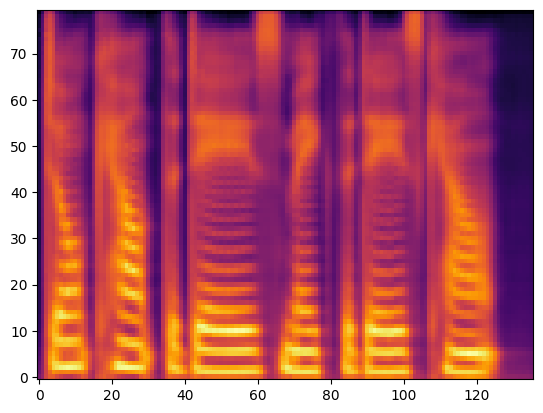

In [12]:
plt.imshow(spect_arr.T, cmap='inferno', aspect='auto', origin='lower');

In [13]:
import IPython as ipy
import librosa

mel_spectrogram = librosa.db_to_amplitude(spect_arr)

In [14]:
sr = 16_000  # Sample rate
n_fft = 2048  # FFT window size
n_mels = mel_spectrogram.shape[0]  # Number of mel bands

# Create mel filter bank and its pseudo-inverse
mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
inv_mel_basis = np.linalg.pinv(mel_basis)

# Convert mel spectrogram to linear spectrogram (STFT)
spectrogram = np.dot(inv_mel_basis, mel_spectrogram)


In [15]:
waveform = librosa.griffinlim(spectrogram, n_iter=1000)

In [16]:
ipy.display.Audio(waveform, rate=16_000)

In [ ]:
from transformers import BarkModel, BarkProcessor

model = BarkModel.from_pretrained('suno/bark-small')
processor = BarkProcessor.from_pretrained('suno/bark-small')

In [18]:
inputs = processor("This is a test!", voice_preset="v2/en_speaker_3")
speech_output = model.generate(**inputs).cpu().numpy()
speech_output.shape

en_speaker_3_semantic_prompt.npy:   0%|          | 0.00/3.54k [00:00<?, ?B/s]

en_speaker_3_coarse_prompt.npy:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

en_speaker_3_fine_prompt.npy:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


(1, 47360)

In [19]:
ipy.display.Audio(speech_output[0], rate=model.generation_config.sample_rate)

In [ ]:
from transformers import VitsModel, VitsTokenizer

model = VitsModel.from_pretrained("facebook/mms-tts-tam")
tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-tam")

In [21]:
text_example = (
    "கொட்டும் பரிசுமழை... ஐபிஎல் 2024 இறுதிப்போட்டியில் வெல்லும் அணிக்கு எவ்வளவு பரிசு தெரியுமா?"
)

In [22]:
import torch
inputs = tokenizer(text_example, return_tensors='pt')
input_ids = inputs['input_ids']
with torch.no_grad():
  output = model(input_ids)

speech = output['waveform']

In [23]:
ipy.display.Audio(speech, rate=16_000)